In [29]:
import cv2


img = cv2.imread('/content/drive/MyDrive/d6/train/fresh_apple/0000.jpg')


print(img.shape)




(160, 160, 3)


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory



In [4]:
PATH = '/content/drive/MyDrive/d6'
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'test')

LABELS = ['fresh_apple', 'fresh_banana', 'fresh_orange', 
          'rotten_apple', 'rotten_banana', 'rotten_orange']
BATCH_SIZE = 32
EPOCHS = 20
IMG_SIZE = (160, 160)

train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             label_mode ='categorical')

Found 10934 files belonging to 6 classes.


In [5]:
validation_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size = BATCH_SIZE,
                                                  image_size = IMG_SIZE,
                                                  label_mode= 'categorical' )

Found 2758 files belonging to 6 classes.


In [6]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [7]:
val_batches_num = tf.data.experimental.cardinality(validation_dataset)
test_batches_num = tf.data.experimental.cardinality(test_dataset)
print('Number of validation batches: %d' % val_batches_num)
print('Number of test batches: %d' % test_batches_num)

Number of validation batches: 70
Number of test batches: 17


In [8]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [16]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [17]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9420800/9406464 [==============================] - 0s 0us/step


In [18]:
base_model.trainable = False

In [19]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [20]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

In [21]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [22]:
prediction_layer = tf.keras.layers.Dense(6, activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 6)


In [23]:


inputs = tf.keras.Input(shape=(160, 160, 3))
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [25]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [26]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                      

In [30]:
history = model.fit(train_dataset,
                    epochs=EPOCHS,
                    validation_data=validation_dataset)

Epoch 1/20
342/342 [==============================] - 4223s 12s/step - loss: 0.6895 - accuracy: 0.7714 - val_loss: 0.3840 - val_accuracy: 0.8939
Epoch 2/20
342/342 [==============================] - 25s 72ms/step - loss: 0.3267 - accuracy: 0.9063 - val_loss: 0.2471 - val_accuracy: 0.9341
Epoch 3/20
342/342 [==============================] - 23s 67ms/step - loss: 0.2302 - accuracy: 0.9353 - val_loss: 0.1930 - val_accuracy: 0.9453
Epoch 4/20
342/342 [==============================] - 23s 67ms/step - loss: 0.1805 - accuracy: 0.9501 - val_loss: 0.1581 - val_accuracy: 0.9575
Epoch 5/20
342/342 [==============================] - 23s 67ms/step - loss: 0.1483 - accuracy: 0.9586 - val_loss: 0.1385 - val_accuracy: 0.9652
Epoch 6/20
342/342 [==============================] - 23s 67ms/step - loss: 0.1274 - accuracy: 0.9641 - val_loss: 0.1260 - val_accuracy: 0.9670
Epoch 7/20
342/342 [==============================] - 23s 68ms/step - loss: 0.1155 - accuracy: 0.9684 - val_loss: 0.1167 - val_accuracy

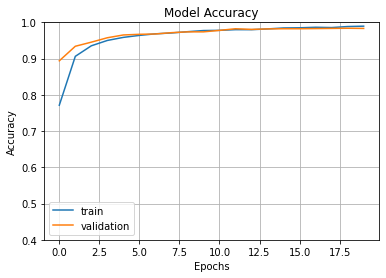

In [31]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

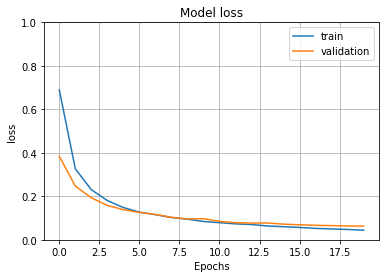

In [34]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.axis(ymin=0,ymax=1)
plt.grid()
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

In [ ]:
model.save("fruit_classifier_v3_transfer_learning.h5")

In [2]:
from keras.models import load_model
model = load_model('/content/fruit_classifier_v3_transfer_learning.h5')

In [9]:
loss_final,accuracy_final=model.evaluate(test_dataset)

17/17 [==============================] - 304s 12s/step - loss: 0.0880 - accuracy: 0.9743


In [11]:
class_names=["fresh_apple","fresh_banana","fresh_orange","rotten_apple","rotten_banana","rotten_orange"]

rotten_orange


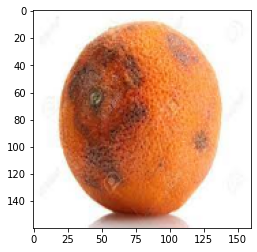

In [13]:
import cv2
image=cv2.imread("/content/download.jfif")
image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

image_resized=cv2.resize(image,(160,160))
plt.imshow(image_resized)
image=np.expand_dims(image_resized,axis=0)
pred=model.predict(image)
output_class=class_names[np.argmax(pred)]
print(output_class)


fresh_banana


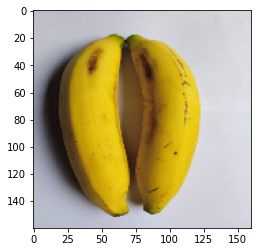

In [14]:
import cv2
image=cv2.imread("/content/FreshBanana (14).jpg")
image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

image_resized=cv2.resize(image,(160,160))
plt.imshow(image_resized)
image=np.expand_dims(image_resized,axis=0)
pred=model.predict(image)
output_class=class_names[np.argmax(pred)]
print(output_class)


rotten_apple


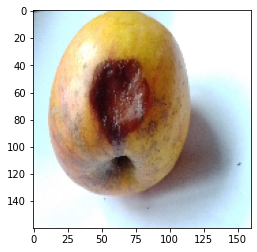

In [19]:

image=cv2.imread("/content/RottenApple (85).jpg")
image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

image_resized=cv2.resize(image,(160,160))
plt.imshow(image_resized)
image=np.expand_dims(image_resized,axis=0)
pred=model.predict(image)
output_class=class_names[np.argmax(pred)]
print(output_class)


rotten_apple


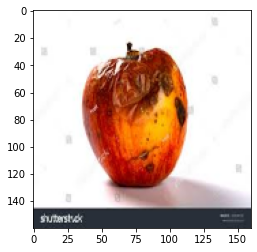

In [20]:

image=cv2.imread("/content/n4.jfif")
image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

image_resized=cv2.resize(image,(160,160))
plt.imshow(image_resized)
image=np.expand_dims(image_resized,axis=0)
pred=model.predict(image)
output_class=class_names[np.argmax(pred)]
print(output_class)


fresh_apple


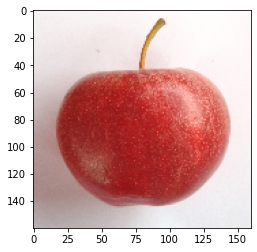

In [21]:

image=cv2.imread("/content/FreshApple (98).jpg")
image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

image_resized=cv2.resize(image,(160,160))
plt.imshow(image_resized)
image=np.expand_dims(image_resized,axis=0)
pred=model.predict(image)
output_class=class_names[np.argmax(pred)]
print(output_class)